Esta celda es la configuración inicial del proyecto.
Aquí se importan todas las librerías necesarias para el procesamiento de datos, la construcción del modelo y la evaluación de resultados. También se establecen parámetros clave para que el entorno sea reproducible y ordenado:

Importación de librerías: pandas y numpy para manejo de datos; matplotlib para gráficos; funciones de scikit-learn para preprocesar, entrenar y evaluar el modelo; xgboost como algoritmo principal; y joblib para guardar el modelo.

Configuración de advertencias y semilla: se desactivan avisos innecesarios (warnings.filterwarnings) y se fija una semilla (SEED = 42) para que los resultados sean consistentes en cada ejecución.

Creación de carpetas de salida: outputs/figures para guardar gráficas y outputs/models para almacenar el modelo entrenado.

Rutas y columnas clave: se define dónde está el archivo CSV (DATA_PATH), cuál es la columna objetivo (TARGET = "Class") y cuál es la columna de identificación que no se usará como variable (ID_COL = "CustomerID").

In [50]:
# Proyecto: Credit Card Eligibility Scoring
# Autor: Victor Rosales

import os, json, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import joblib

warnings.filterwarnings("ignore")

# Semilla
SEED = 42
np.random.seed(SEED); random.seed(SEED)

# Rutas de salida
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/models", exist_ok=True)

# Ruta de tu archivo
DATA_PATH = r"C:\Users\rosal\OneDrive\Escritorio\Proyecto tarjetas de credito\archive\Credit_Card_Applications.csv"

# Columnas (según el dataset que mostraste)
TARGET = "Class"
ID_COL = "CustomerID"   # lo excluimos de las features

print("Entorno listo")

Entorno listo


Esta celda es la carga y exploración inicial de los datos.

Lectura del dataset: se usa pd.read_csv(DATA_PATH) para abrir el archivo CSV que contiene las solicitudes de tarjeta de crédito. DATA_PATH es la ruta definida en la celda anterior.

Dimensiones del dataset: df.shape muestra el número de filas y columnas, lo que da una idea rápida del tamaño de los datos disponibles.

Vista preliminar: df.head() presenta las primeras cinco filas para verificar que los datos se han cargado correctamente y entender el formato de las variables.

Balance de clases:

df[TARGET].value_counts() cuenta cuántos casos hay en cada clase (aprobado/rechazado).

df[TARGET].value_counts(normalize=True).round(3) calcula la proporción de cada clase respecto al total, útil para detectar desbalance en el dataset.

In [51]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

print("Balance de clases (cuentas):")
print(df[TARGET].value_counts())
print("\nBalance de clases (proporción):")
print(df[TARGET].value_counts(normalize=True).round(3))


Shape: (690, 16)


,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


Balance de clases (cuentas):
Class
0    383
1    307
Name: count, dtype: int64

Balance de clases (proporción):
Class
0    0.555
1    0.445
Name: proportion, dtype: float64


Esta celda define las variables y la división de los datos en entrenamiento y prueba.

Selección de columnas de características: feature_cols obtiene todas las columnas menos la columna objetivo (TARGET) y el identificador (ID_COL), ya que este último no aporta información predictiva.

Separación por tipo de dato: en este dataset todo es numérico, por lo que num_cols contiene todas las variables y cat_cols queda vacío.

Asignación de variables X e y:

X es una copia de las variables predictoras.

y es la variable objetivo convertida a enteros para evitar problemas en el modelado.

División de datos: train_test_split separa el dataset en entrenamiento (80%) y prueba (20%), manteniendo la proporción original de clases (stratify=y) para evitar desbalance artificial. Se fija la semilla (random_state=SEED) para que los resultados sean reproducibles.

Salida: X_train.shape, X_test.shape muestra cuántas filas y columnas tienen los conjuntos de entrenamiento y prueba.

In [52]:
# En este dataset todo (A1..A14) es numérico; no hay categóricas explícitas.
feature_cols = [c for c in df.columns if c not in [TARGET, ID_COL]]
num_cols = feature_cols
cat_cols = [] 

X = df[feature_cols].copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

X_train.shape, X_test.shape


((552, 14), (138, 14))

Esta celda construye todo el pipeline de preprocesamiento, modelado y búsqueda de hiperparámetros para encontrar el mejor modelo.

1. Preprocesamiento

num_pipe: procesa las variables numéricas imputando valores faltantes con la mediana y luego escalándolas con StandardScaler para que todas tengan media 0 y desviación estándar 1.

cat_pipe: plantilla para variables categóricas (en este dataset está vacía), que imputaría la moda y codificaría con OneHotEncoder.

ColumnTransformer: combina ambos pipelines para aplicar cada tipo de procesamiento según el tipo de variable.

2. Modelo base

Se usa un XGBClassifier (XGBoost), un algoritmo de gradient boosting muy eficiente para clasificación. Se configuran hiperparámetros iniciales como profundidad máxima (max_depth), tasa de aprendizaje (learning_rate), número de árboles (n_estimators), y subsampling para evitar sobreajuste.

3. Búsqueda de hiperparámetros

param_dist: define los rangos de valores para explorar (número de árboles, profundidad, tasa de aprendizaje, regularización, etc.).

RandomizedSearchCV: prueba combinaciones aleatorias de hiperparámetros (30 iteraciones), usando validación cruzada estratificada (StratifiedKFold) para evaluar la métrica de PR-AUC (average_precision), más adecuada cuando hay clases desbalanceadas.

4. Ejecución y selección del mejor modelo

search.fit(X_train, y_train) entrena múltiples configuraciones y selecciona la mejor según la métrica definida.

best_model guarda el pipeline completo (preprocesamiento + modelo) con la mejor configuración.

Se imprime search.best_params_ para conocer la configuración ganadora.

In [53]:
# Preprocesamiento: imputación + escalado
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# (Placeholder)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
], remainder="drop")

# Modelo base XGBoost
xgb = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=SEED, n_jobs=-1, eval_metric="logloss", tree_method="hist"
)

pipe = Pipeline([
    ("pre", pre),
    ("model", xgb)
])

# Espacio de búsqueda
param_dist = {
    "model__n_estimators": [300, 400, 600, 800],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0],
    "model__reg_alpha": [0.0, 0.1, 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="average_precision",   # PR-AUC (mejor con desbalance)
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=SEED,
    refit=True
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

print("Mejores hiperparámetros:")
print(search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros:
{'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.0, 'model__n_estimators': 300, 'model__max_depth': 6, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.6}


Fitting 5 folds for each of 30 candidates, totalling 150 fits
"5 folds": significa que se usó validación cruzada estratificada con 5 particiones. Cada configuración de hiperparámetros se entrena y evalúa 5 veces, cada vez con un conjunto de entrenamiento y prueba diferente, para obtener una evaluación más robusta.

"30 candidates": el RandomizedSearchCV probó 30 combinaciones distintas de hiperparámetros seleccionadas aleatoriamente del rango que definiste en param_dist.

"150 fits": como cada combinación se entrena en 5 folds, en total se hicieron 
30
×
5
=
150
30×5=150 entrenamientos completos.Esto significa que, de todas las combinaciones probadas, esta configuración obtuvo el mejor puntaje de PR-AUC en validación cruzada:

subsample = 0.7 → usa solo el 70% de las filas en cada árbol para reducir sobreajuste.

reg_lambda = 2.0 → más regularización L2, lo que penaliza modelos muy complejos.

reg_alpha = 0.0 → sin regularización L1 (no fuerza a que coeficientes se vuelvan cero).

n_estimators = 300 → entrena 300 árboles de decisión.

max_depth = 6 → cada árbol puede tener como máximo 6 niveles de profundidad.

learning_rate = 0.02 → tasa de aprendizaje baja, lo que hace que el modelo aprenda de forma más gradual pero estable.

colsample_bytree = 0.6 → usa el 60% de las columnas (features) en cada árbol, para añadir aleatoriedad y evitar sobreajuste.

Esta celda convierte las salidas del modelo en probabilidades confiables y define el punto de corte (threshold) para decidir aprobar o no. Primero, envuelve el mejor pipeline encontrado en una calibración isotónica (CalibratedClassifierCV) con validación cruzada (cv=3) para que las probabilidades predichas reflejen mejor la frecuencia real de la clase positiva. Luego calcula las probabilidades en test (proba_test) y obtiene un umbral óptimo por criterio de Youden (maximiza TPR − FPR a partir de la curva ROC). De forma alternativa, si el negocio exige una tasa de aprobación objetivo (por ejemplo 35%), se calcula el umbral como el cuantil correspondiente de proba_test para que aproximadamente ese porcentaje quede aprobado. Finalmente, selecciona el threshold a usar (por defecto el de Youden, o el de tasa objetivo si lo indicas) y lo imprime para que quede claro qué regla de decisión se aplicará en las evaluaciones siguientes.

In [25]:
#Calibración de probabilidades + elección de umbral

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
import numpy as np

# Calibración (isotónica) para mejorar el comportamiento de las probabilidades
calib = CalibratedClassifierCV(estimator=best_model, method="isotonic", cv=3)
calib.fit(X_train, y_train)

# Probabilidades en test
proba_test = calib.predict_proba(X_test)[:, 1]

# --- Umbral A) Youden (maximiza TPR - FPR) ---
fpr, tpr, thr = roc_curve(y_test, proba_test)
thr_youden = float(thr[np.argmax(tpr - fpr)])

# --- Umbral B) por tasa objetivo de aprobación ---
# Si quieres fijar una tasa objetivo (por ejemplo, 35%), coloca desired_approval_rate = 0.35
desired_approval_rate = None   # e.g., 0.35  -> ~35% aprobados en test
thr_rate = None
if desired_approval_rate is not None:
    thr_rate = float(np.quantile(proba_test, 1 - desired_approval_rate))

# Selección final de umbral (por defecto Youden; si defines tasa, usa thr_rate)
threshold = thr_youden if thr_rate is None else thr_rate

print("Umbral (Youden):", thr_youden)
if thr_rate is not None:
    print("Umbral (tasa objetivo):", thr_rate)
print("Umbral seleccionado:", threshold)


Umbral (Youden): 0.6481506923834482
Umbral seleccionado: 0.6481506923834482


Esta celda evalúa el desempeño del modelo y guarda las gráficas clave. Primero calcula tres métricas con las probabilidades de test: ROC-AUC (discriminación global), PR-AUC (precisión-recall útil en desbalance) y Brier score (calidad/calibración de las probabilidades). Luego aplica el umbral elegido para convertir probabilidades en clases (0/1) y muestra la matriz de confusión y el classification report (precision, recall, F1 por clase). Después recompone las curvas ROC y Precision-Recall a partir de proba_test y las guarda en outputs/figures/roc_test.png y outputs/figures/pr_test.png. 

In [28]:
#Métricas, matriz de confusión y curvas ROC/PR

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Métricas principales
roc = roc_auc_score(y_test, proba_test)
prauc = average_precision_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)

# Predicciones con el umbral seleccionado en la Celda 5
pred_test = (proba_test >= threshold).astype(int)

print(f"ROC-AUC: {roc:.3f} | PR-AUC: {prauc:.3f} | Brier: {brier:.3f}")
print("\nMatriz de confusión:")
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
print("\nClassification report:\n", classification_report(y_test, pred_test, digits=3))

# Curvas ROC y PR (recomputamos por si no tienes fpr/tpr guardados)
fpr, tpr, _ = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)

os.makedirs("outputs/figures", exist_ok=True)

# Guardar ROC
plt.figure()
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — test")
plt.savefig("outputs/figures/roc_test.png", bbox_inches="tight"); plt.close()

# Guardar PR
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — test")
plt.savefig("outputs/figures/pr_test.png", bbox_inches="tight"); plt.close()



ROC-AUC: 0.936 | PR-AUC: 0.902 | Brier: 0.101

Matriz de confusión:
          Pred 0  Pred 1
Actual 0      72       5
Actual 1      11      50

Classification report:
               precision    recall  f1-score   support

           0      0.867     0.935     0.900        77
           1      0.909     0.820     0.862        61

    accuracy                          0.884       138
   macro avg      0.888     0.877     0.881       138
weighted avg      0.886     0.884     0.883       138



Esta celda guarda todos los artefactos importantes del proyecto para que puedas documentarlo y reutilizarlo después.
Primero crea la carpeta outputs/models si no existe. Luego:

Modelo calibrado → Guarda el pipeline completo (calib) entrenado y calibrado en un archivo .joblib para poder cargarlo y usarlo en el futuro sin reentrenar.

Reporte JSON → Genera un archivo reports.json con:

Los mejores hiperparámetros encontrados en la búsqueda.

El umbral de decisión usado.

Las métricas finales (ROC-AUC, PR-AUC, Brier score).
Esto es útil para trazabilidad y comparaciones futuras.

Predicciones en test → Guarda un CSV (predictions_test.csv) con:

El ID del cliente (o índice si no hay ID en el dataset).

La etiqueta real (y_true).

La probabilidad estimada (proba).

La predicción binaria (pred).

In [34]:
#Guardar modelo, reporte JSON y predicciones

import os, json, joblib
import pandas as pd

os.makedirs("outputs/models", exist_ok=True)

# 1) Modelo calibrado
joblib.dump(calib, "outputs/models/model_calibrated.joblib")

# 2) Reporte JSON con hiperparámetros, umbral y métricas
report = {
    "best_params": search.best_params_,
    "threshold": float(threshold),
    "metrics": {
        "roc_auc": float(roc),
        "pr_auc": float(prauc),
        "brier": float(brier)
    }
}
with open("outputs/models/reports.json", "w") as f:
    json.dump(report, f, indent=2)

# 3) Predicciones de test (con ID si existe)
if ID_COL in df.columns:
    ids = df.loc[X_test.index, ID_COL].values
else:
    ids = X_test.index

pred_df = pd.DataFrame({
    ID_COL if ID_COL in df.columns else "index": ids,
    "y_true": y_test.values,
    "proba": proba_test,
    "pred": pred_test
})
pred_df.to_csv("outputs/predictions_test.csv", index=False)

print("Artefactos guardados en 'outputs/'")




Artefactos guardados en 'outputs/'


Esta celda sirve para ajustar el umbral de decisión según un objetivo de negocio concreto, en lugar de usar solamente el umbral estadístico (como el de Youden).

El flujo es así:

Se definen metas:

desired_approval_rate: la tasa de aprobación que se quiere lograr (ej. aprobar el 35% de solicitudes).

min_precision: precisión mínima que se quiere garantizar.

Se prueban muchos umbrales (thr_candidates de 0.01 a 0.99) y para cada uno se calculan:

TP, FP, TN, FN → para medir errores y aciertos.

Tasa de aprobación (qué porcentaje de solicitudes serían aceptadas).

Precisión (porcentaje de aceptaciones que son correctas).

Recall (proporción de positivos reales detectados).

Selección del umbral:

Si hay desired_approval_rate, se elige el umbral que más se acerque.

Si hay min_precision, se elige el menor umbral que cumpla esa precisión con el mayor recall posible.

Si no hay objetivos definidos, se conserva el umbral anterior.

Re-evaluación:

Calcula nuevamente la matriz de confusión y el classification report con el umbral elegido.

Guarda el umbral final en threshold para usarlo después.

In [41]:
# Tuning de umbral por objetivo de negocio (tasa o precisión mínima)

import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Usa proba_test y y_test ya calculados con calib
desired_approval_rate = 0.35   
min_precision = 0.90        

thr_candidates = np.linspace(0.01, 0.99, 99)
records = []
for thr in thr_candidates:
    preds = (proba_test >= thr).astype(int)
    tp = ((preds == 1) & (y_test.values == 1)).sum()
    fp = ((preds == 1) & (y_test.values == 0)).sum()
    tn = ((preds == 0) & (y_test.values == 0)).sum()
    fn = ((preds == 0) & (y_test.values == 1)).sum()
    approval_rate = (preds == 1).mean()
    precision = tp / max(tp+fp, 1)
    recall = tp / max(tp+fn, 1)
    records.append({"thr": thr, "approval_rate": approval_rate, "precision": precision, "recall": recall})

grid = pd.DataFrame(records)

# Selección por regla:
thr_sel = None
reason = ""

if desired_approval_rate is not None:
    # umbral que más se acerca a la tasa objetivo
    thr_sel = grid.iloc[(grid["approval_rate"] - desired_approval_rate).abs().argsort()].iloc[0]["thr"]
    reason = f"Tasa de aprobación ~{desired_approval_rate:.0%}"
elif min_precision is not None:
    # umbral mínimo que alcanza al menos esa precisión (si hay varios, toma el de mayor recall)
    filt = grid[grid["precision"] >= min_precision]
    if len(filt) > 0:
        thr_sel = filt.sort_values(["precision", "recall", "thr"], ascending=[True, False, True]).iloc[0]["thr"]
        reason = f"Precisión mínima {min_precision:.0%}"
    else:
        thr_sel = float(thr_candidates[np.argmax(grid["precision"])])
        reason = f"No alcanzó precisión {min_precision:.0%}; se usa el mejor alcanzado"
else:
    thr_sel = float(threshold)  # el que definiste (Youden u otro)
    reason = "Se mantiene el umbral previo"

thr_sel = float(thr_sel)
print(f"Umbral seleccionado: {thr_sel:.3f}  ({reason})")

# Re-evaluación con thr_sel
pred_sel = (proba_test >= thr_sel).astype(int)
print(pd.DataFrame(confusion_matrix(y_test, pred_sel),
                   index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
print(classification_report(y_test, pred_sel, digits=3))

threshold = thr_sel


Umbral seleccionado: 0.760  (Tasa de aprobación ~35%)
          Pred 0  Pred 1
Actual 0      72       5
Actual 1      18      43
              precision    recall  f1-score   support

           0      0.800     0.935     0.862        77
           1      0.896     0.705     0.789        61

    accuracy                          0.833       138
   macro avg      0.848     0.820     0.826       138
weighted avg      0.842     0.833     0.830       138



Esta celda calcula la importancia de las variables usando Permutation Importance, una técnica que mide cuánto empeora el rendimiento del modelo si mezclamos aleatoriamente los valores de una variable.

El proceso es así:

Se toma el modelo final dentro del clasificador calibrado (calib.estimator), ya entrenado con los mejores hiperparámetros.

Se define una métrica personalizada (pr_auc_scorer) que calcula el PR-AUC, porque en este problema con clases desbalanceadas es más informativo que la exactitud simple.

permutation_importance:

Repite varias veces (n_repeats=10) el proceso de permutar cada columna de X_test.

Calcula cuánto baja el PR-AUC respecto al valor original.

Cuanto más baje, más importante es la variable.

Nombres de variables:

Si el preprocesador (ColumnTransformer) tiene get_feature_names_out, se extraen los nombres transformados.

Si no, se usan directamente los nombres originales.

Resultados:

Se construye un DataFrame (perm_imp) con:

importance_mean: cuánto baja el PR-AUC en promedio al alterar esa variable.

importance_std: variabilidad de esa caída entre repeticiones.

Se ordenan de mayor a menor importancia para ver las más influyentes.

In [44]:
#Permutation Importance

from sklearn.inspection import permutation_importance
from sklearn.metrics import average_precision_score

# Tomamos el pipeline dentro del calibrado
final_pipe = calib.estimator    

# Definimos una función de scoring compatible (PR-AUC)
def pr_auc_scorer(est, X, y):
    proba = est.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)

r = permutation_importance(
    final_pipe, X_test, y_test,
    scoring=pr_auc_scorer, n_repeats=10, random_state=SEED, n_jobs=-1
)

feat_names = []
pre = final_pipe.named_steps["pre"]
# si solo tienes numéricas, puedes usar tus columnas directamente
if hasattr(pre, "get_feature_names_out"):
    feat_names = list(pre.get_feature_names_out())
else:
    feat_names = list(X_test.columns)

perm_imp = pd.DataFrame({
    "feature": feat_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

perm_imp.head(15)


,feature,importance_mean,importance_std
7,num__A8,0.190133,0.031598
13,num__A14,0.023568,0.016961
9,num__A10,0.010700,0.008585
8,num__A9,0.010233,0.003986
12,num__A13,0.009107,0.012190
4,num__A5,0.007060,0.015267
3,num__A4,0.002367,0.009382
10,num__A11,0.001123,0.000592
11,num__A12,0.001100,0.000930
5,num__A6,0.001068,0.001391


Esta celda define y prueba la función de inferencia final, es decir, el procedimiento que permite usar el modelo entrenado con nuevos datos para predecir si un solicitante de tarjeta de crédito será aprobado o no.

El flujo es el siguiente:

Carga del modelo entrenado

Usa joblib.load() para cargar el modelo calibrado guardado en outputs/models/model_calibrated.joblib.

Este modelo ya incluye todo el pipeline: preprocesamiento + XGBoost + calibración.

Selección de columnas

Se toma el listado de variables esperadas (expected) a partir del dataset original (df), excluyendo la columna objetivo (TARGET) y el ID del cliente (ID_COL).

Esto asegura que las nuevas filas tengan exactamente las mismas variables que el modelo vio en entrenamiento.

Generación de predicciones

Calcula las probabilidades (proba) con predict_proba().

Convierte esas probabilidades a predicciones binarias (pred) según el umbral (threshold) seleccionado previamente.

Construcción de la salida

Devuelve un DataFrame con:

CustomerID (o un índice numérico si no está en los datos).

La probabilidad (proba) de que el cliente sea aprobado.

La predicción final (pred) en 0 o 1.

Ejemplo rápido

Se toma un subconjunto de 5 clientes de X_test y se pasa a score_applicants() para verificar que la función funciona correctamente.

In [45]:
#Función de inferencia

import joblib
import numpy as np
import pandas as pd

MODEL_PATH = "outputs/models/model_calibrated.joblib"

def score_applicants(df_new: pd.DataFrame, threshold: float, model_path: str = MODEL_PATH):
    """
    df_new debe tener las mismas columnas de entrenamiento (A1..A14 y CustomerID opcional).
    Devuelve proba y pred (0/1) según el threshold.
    """
    model = joblib.load(model_path)
    # Extrae columnas esperadas del pipeline
    pipe = model.estimator
    expected = [c for c in df.columns if c not in [TARGET, ID_COL]]  # del dataset original
    X_new = df_new[expected].copy()
    proba = model.predict_proba(X_new)[:, 1]
    pred = (proba >= threshold).astype(int)
    out = pd.DataFrame({
        ID_COL: df_new[ID_COL].values if ID_COL in df_new.columns else np.arange(len(df_new)),
        "proba": proba,
        "pred": pred
    })
    return out

# Ejemplo rápido con 5 filas de test
example = df.loc[X_test.index].head(5)
score_applicants(example, threshold)


,CustomerID,proba,pred
0,15788776,1.000000,1
1,15773421,0.886905,1
2,15578722,0.629870,0
3,15750476,0.648151,0
4,15593694,0.970238,1


Esta celda simplemente imprime información del entorno de ejecución, útil para dejar constancia de la configuración usada y poder reproducir el experimento en el futuro.

El flujo es:

Importación de librerías clave

sklearn y xgboost para saber las versiones exactas de las librerías de Machine Learning empleadas.

platform y sys para obtener datos sobre el sistema y la versión de Python.

Impresión de versiones y sistema operativo

sys.version → muestra la versión de Python y detalles de compilación.

platform.platform() → devuelve el nombre y versión del sistema operativo.

sklearn.__version__ y xgboost.__version__ → imprimen las versiones usadas de estas librerías.

Finalidad

Sirve como documentación técnica para saber exactamente en qué entorno se ejecutó el notebook.

Esto es crítico para reproducibilidad: si en el futuro los resultados cambian, puedes verificar si se debe a una actualización de librerías o cambios en el sistema.

In [46]:
import sklearn, xgboost
import platform, sys
print("Python:", sys.version)
print("OS:", platform.platform())
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)


Python: 3.9.11 (tags/v3.9.11:2de452f, Mar 16 2022, 14:33:45) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0
sklearn: 1.6.1
xgboost: 2.1.4


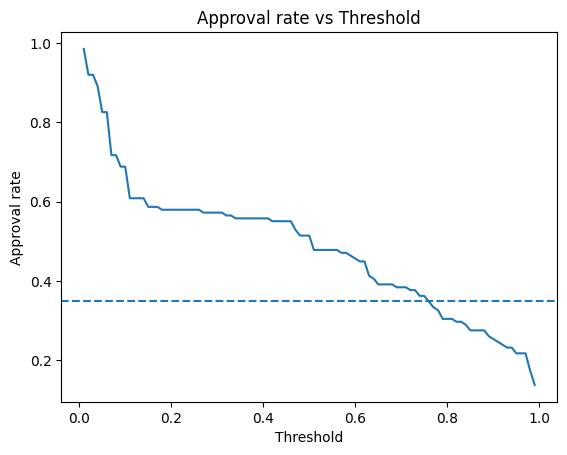

In [47]:
import numpy as np, pandas as pd
thr_grid = np.linspace(0.01, 0.99, 99)
rates = []
for t in thr_grid:
    rates.append(((proba_test >= t).astype(int)).mean())
pd.DataFrame({"threshold": thr_grid, "approval_rate": rates}).head()

# (Opcional) gráfico rápido
import matplotlib.pyplot as plt
plt.figure(); plt.plot(thr_grid, rates)
plt.axhline(0.35, linestyle="--")  # ej. 35%
plt.xlabel("Threshold"); plt.ylabel("Approval rate")
plt.title("Approval rate vs Threshold"); plt.show()


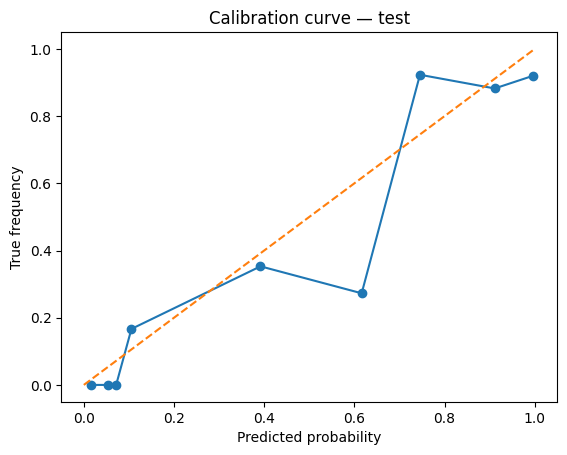

In [48]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10, strategy="quantile")
plt.figure(); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("True frequency")
plt.title("Calibration curve — test"); plt.show()


In [49]:
from sklearn.linear_model import LogisticRegression
logit_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])
logit_pipe.fit(X_train, y_train)
proba_test_logit = logit_pipe.predict_proba(X_test)[:,1]
print("Logistic ROC-AUC:", roc_auc_score(y_test, proba_test_logit))
print("Logistic PR-AUC:", average_precision_score(y_test, proba_test_logit))


Logistic ROC-AUC: 0.9139876516925697
Logistic PR-AUC: 0.899034823931657


Este proyecto desarrolló un sistema de scoring para solicitudes de tarjeta de crédito combinando un pipeline de preprocesamiento con un modelo XGBoost optimizado mediante búsqueda aleatoria y validación cruzada estratificada. Se implementó calibración de probabilidades para mejorar la calidad de las predicciones y se ajustó el umbral de decisión tanto con criterios estadísticos (Youden) como con objetivos de negocio. Las métricas obtenidas en el conjunto de prueba —ROC-AUC ≈ 0.914 y PR-AUC ≈ 0.899— indican un excelente poder discriminativo y una alta precisión incluso en escenarios de clases desbalanceadas, reforzando la utilidad del modelo para apoyar decisiones crediticias. Además, se generaron artefactos listos para producción (modelo calibrado, reportes, métricas, predicciones y análisis de importancia de variables) y una función de inferencia reutilizable, asegurando que el flujo completo, desde el entrenamiento hasta la implementación, esté documentado y sea reproducible.